In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [2]:
train_data_dir = '/kaggle/input/melanomadataset/train'
test_data_dir = '/kaggle/input/melanomadataset/test'

In [3]:
image_size = (224, 224)
batch_size = 32

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.2,)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
validation_generator

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(320, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(320, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [9]:
for data_batch, labels_batch in validation_generator:
    print("Validation data batch shape:", data_batch.shape)
    print("Validation labels batch shape:", labels_batch.shape)
    break  # Only check the first batch

Validation data batch shape: (32, 224, 224, 3)
Validation labels batch shape: (32, 2)


In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717531606.826557    1034 service.cc:145] XLA service 0x7ed2bc0043c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717531606.826597    1034 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1717531606.826601    1034 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1717531639.857692    1034 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1717531639.902

297/297 ━━━━━━━━━━━━━━━━━━━━ 158s 309ms/step - accuracy: 0.8235 - loss: 0.4703 - val_accuracy: 0.5291 - val_loss: 2.9570
Epoch 2/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 2.6421
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 295ms/step - accuracy: 0.8801 - loss: 0.3050 - val_accuracy: 0.5291 - val_loss: 1.4387
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 1.2744
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 296ms/step - accuracy: 0.8847 - loss: 0.2741 - val_accuracy: 0.6022 - val_loss: 1.1334
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 1.3855
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 295ms/step - accuracy: 0.8950 - loss: 0.2572 - val_accuracy: 0.7863 - val_loss: 0.4981
Epoch 8/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.4383
Epoch 9/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 295ms/step - accuracy: 0

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.8728 - loss: 0.2747
Test Loss: 0.26877355575561523
Test Accuracy: 0.8794999718666077


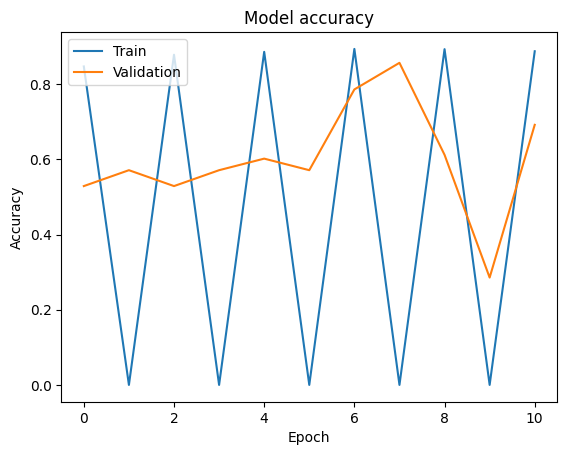

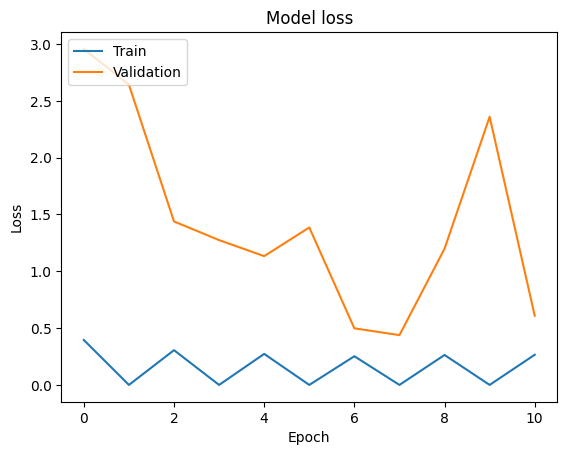

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [13]:
# # Define the directories
# train_data_dir = '/kaggle/input/melanomadataset/train'
# test_data_dir = '/kaggle/input/melanomadataset/test'

# # Function to list image files in a directory
# def list_image_files(directory):
#     image_files = []
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             if file.endswith(".jpg"):
#                 image_files.append(os.path.join(root, file))
#     return image_files

# # List all image files in the train directory
# all_train_files = list_image_files(train_data_dir)

# # Split the data into training and testing sets
# train_files, test_files = train_test_split(all_train_files, test_size=0.2, random_state=42)

# # Split the training data into training and validation sets
# train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

# # Define directory paths for training, validation, and testing
# train_dir = '/kaggle/working/train_split/train'
# val_dir = '/kaggle/working/train_split/validation'
# test_dir = '/kaggle/working/test_split/test'

# # Create directories if they don't exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Copy training files
# for file in train_files:
#     shutil.copy(file, train_dir)

# # Copy validation files
# for file in val_files:
#     shutil.copy(file, val_dir)

# # Copy testing files
# for file in test_files:
#     shutil.copy(file, test_dir)

# print("Files copied successfully!")